In [107]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pyinform pyunicorn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ERROR: Could not find a version that satisfies the requirement nolitsa (from versions: none)
ERROR: No matching distribution found for nolitsa


# Imports

In [111]:
import numpy as np
import glob
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from scipy.signal import argrelextrema
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.stats import mode
from joblib import Parallel, delayed
from pyinform.mutualinfo import mutual_info
from pyunicorn.timeseries import RecurrencePlot
from statsmodels.tsa.stattools import acf
from scipy.spatial import KDTree

# Optimal Time Delay Functions

In [24]:
def compute_mi_sklearn(signal, max_tau=50):
    """
    Computes Mutual Information (MI) between the original signal and its time-delayed version
    using sklearn's mutual_info_regression (which works for continuous signals). Also finds the
    optimal time delay (τ) as the first local minimum of MI.

    Parameters:
    - signal: 1D NumPy array representing the input time series signal.
    - max_tau: Integer, maximum time delay to evaluate (default is 50).

    Returns:
    - mi_values: NumPy array of MI values for each time delay from 1 to max_tau-1.
    - optimal_tau: Integer, first local minimum of MI (if found), otherwise global min.
    """

    mis = []  # List to store MI values for different time delays

    # Ensure the signal is a NumPy array
    signal = np.array(signal, dtype=np.float64)

    # Loop through different time delays from 1 to max_tau-1
    for tau in range(1, max_tau):
        # Extract original and delayed signal for given tau
        original = signal[:-tau].reshape(-1, 1)  # Reshape for sklearn compatibility
        delayed = signal[tau:]
        # Compute mutual information
        mi_value = mutual_info_regression(original, delayed)[0]
        mis.append(mi_value)

    # Convert to NumPy array
    mi_values = np.array(mis)

    # Find the first local minimum of MI
    minima_indices = argrelextrema(mi_values, np.less)[0]
    optimal_tau = minima_indices[0] + 1 if len(minima_indices) > 0 else np.argmin(mi_values) + 1

    return mi_values, optimal_tau


def compute_avg_mutual_info(signal, max_tau=50, bins=15):
    """
    Computes Average Mutual Information (AMI) between the original signal and its time-delayed version
    using pyinform's mutual_info function (which requires discrete inputs).

    Also finds the optimal time delay (τ) as the first local minimum of AMI.

    Parameters:
    - signal: 1D NumPy array representing the input time series signal.
    - max_tau: Integer, maximum time delay to evaluate (default = 50).
    - bins: Number of discrete bins to use for signal discretization (default = 10).

    Returns:
    - ami_values: NumPy array of AMI values for each time delay from 1 to max_tau-1.
    - optimal_tau: Integer, first local minimum of AMI (if found), otherwise global min.
    """

    # Ensure the signal is a NumPy array
    signal = np.array(signal, dtype=np.float64)

    # Step 1: Normalize the signal between 0 and 1
    signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

    # Step 2: Discretize into bins
    signal = np.round(signal * (bins - 1)).astype(int)  # Convert to integers

    ami_values = []  # List to store AMI values for different time delays

    # Loop through different time delays from 1 to max_tau-1
    for tau in range(1, max_tau):
        # Compute mutual information (discrete)
        ami_value = mutual_info(signal[:-tau], signal[tau:])
        ami_values.append(ami_value)

    # Convert to NumPy array
    ami_values = np.array(ami_values)

    # Find the first local minimum of AMI
    minima_indices = argrelextrema(ami_values, np.less)[0]
    optimal_tau = minima_indices[0] + 1 if len(minima_indices) > 0 else np.argmin(ami_values) + 1

    return ami_values, optimal_tau


def compute_acf_tau(signal, max_lag=50):
    """
    Computes the Autocorrelation Function (ACF) for a given signal and determines the optimal
    time delay (τ) where ACF first drops below 1/e.

    Parameters:
    - signal: 1D NumPy array, the input time series.
    - max_lag: Maximum number of lags to compute ACF (default = 50).

    Returns:
    - acf_values: NumPy array of ACF values for lags 0 to max_lag.
    - tau_acf: Integer, the first lag where ACF drops below 1/e.
    """
    # Compute autocorrelation function (ACF)
    acf_values = acf(signal, nlags=max_lag, fft=True)  # Use FFT for speed
    # Find the first index where ACF drops below 1/e (~0.3679)
    tau_acf = np.where(acf_values < np.exp(-1))[0][0] if np.any(acf_values < np.exp(-1)) else max_lag
    # return ACF values and the optimal tau determined by ACF
    return acf_values, tau_acf


In [47]:
def compute_optimal_tau(signal, max_tau):
    """
    Computes the optimal time delay (τ) for phase-space reconstruction using three different methods:
    - Mutual Information (MI)
    - Average Mutual Information (AMI)
    - Autocorrelation Function (ACF)

    Parameters:
    - signal (numpy.ndarray): 1D NumPy array representing the input time series signal.
    - max_tau (int): Maximum time delay (τ) to evaluate.

    Returns:
    - dict: A dictionary containing:
        - "mi_values" (numpy.ndarray): Mutual Information values for each τ.
        - "tau_mi" (int): Optimal τ determined from the first local minimum of MI.
        - "ami_values" (numpy.ndarray): Average Mutual Information values for each τ.
        - "tau_ami" (int): Optimal τ determined from the first local minimum of AMI.
        - "acf_values" (numpy.ndarray): Autocorrelation values for each τ.
        - "tau_acf" (int): Optimal τ determined as the first point where ACF drops below 1/e.

    Notes:
    - MI and AMI are better for capturing **both linear and nonlinear dependencies**.
    - ACF only detects **linear correlations**, so it may underestimate τ in complex systems.
    - Comparing all three methods helps ensure a robust choice of τ for phase-space embedding.
    """

    # Compute Mutual Information (MI)
    mi_values, tau_mi = compute_mi_sklearn(signal, max_tau=max_tau)

    # Compute Average Mutual Information (AMI)
    ami_values, tau_ami = compute_avg_mutual_info(signal, max_tau=max_tau)

    # Compute Autocorrelation Function (ACF)
    acf_values, tau_acf = compute_acf_tau(signal, max_lag=max_tau)

    # Store results in a dictionary
    results = {
        "mi_values": mi_values,
        "tau_mi": tau_mi,
        "ami_values": ami_values,
        "tau_ami": tau_ami,
        "acf_values": acf_values,
        "tau_acf": tau_acf
    }

    return results


In [102]:
def plot_tau_results(results):
    """
    Plots the results from Mutual Information (MI), Average Mutual Information (AMI),
    and Autocorrelation Function (ACF) on a dual-axis graph to compare the estimated
    optimal time delay (τ) from each method.

    The legend is manually ordered to prioritize MI, AMI, and ACF first, followed by their respective optimal τ.

    Parameters:
    - results (dict): Dictionary containing:
        - "mi_values" (numpy.ndarray): MI values for each τ.
        - "tau_mi" (int): Optimal τ from MI.
        - "ami_values" (numpy.ndarray): AMI values for each τ.
        - "tau_ami" (int): Optimal τ from AMI.
        - "acf_values" (numpy.ndarray): ACF values for each τ.
        - "tau_acf" (int): Optimal τ from ACF.

    Returns:
    - None: Displays the plot.
    """

    # Extract values from the dictionary
    mi_values = results["mi_values"]
    tau_mi = results["tau_mi"]

    ami_values = results["ami_values"]
    tau_ami = results["tau_ami"]

    acf_values = results["acf_values"]
    tau_acf = results["tau_acf"]

    # Define x-axis (time delays)
    taus = range(1, len(mi_values) + 1)

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Primary Y-Axis (MI & AMI)
    ax1.set_xlabel("Time Delay (τ)")
    ax1.set_ylabel("MI / AMI", color="tab:blue")
    mi_line, = ax1.plot(taus, mi_values, linestyle='-', color="tab:red", label="MI")
    ami_line, = ax1.plot(taus, ami_values, linestyle='-', color="tab:blue", label="AMI")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    # Secondary Y-Axis (ACF)
    ax2 = ax1.twinx()
    ax2.set_ylabel("ACF", color="tab:green")
    acf_line, = ax2.plot(taus, acf_values[:len(taus)], linestyle='-', color="tab:green", label="ACF")
    ax2.tick_params(axis='y', labelcolor="tab:green")

    # Plot vertical lines for optimal τ values
    tau_mi_line = ax1.axvline(tau_mi, color='r', linestyle='--', label=f"Optimal MI τ = {tau_mi}")
    tau_ami_line = ax1.axvline(tau_ami, color='b', linestyle='--', label=f"Optimal AMI τ = {tau_ami}")
    tau_acf_line = ax2.axvline(tau_acf, color='g', linestyle='--', label=f"Optimal ACF τ = {tau_acf}")

    # Manually order legend items
    handles = [mi_line, ami_line, acf_line, tau_mi_line, tau_ami_line, tau_acf_line]
    labels = ["MI", "AMI", "ACF", f"Optimal MI τ = {tau_mi}", f"Optimal AMI τ = {tau_ami}", f"Optimal ACF τ = {tau_acf}"]

    # Add ordered legend
    ax1.legend(handles, labels, loc="upper right")

    # Title and grid
    plt.title("Comparison of MI, AMI, and ACF vs. Time Delay")
    plt.grid(False)

    # Show plot
    plt.show()


In [ ]:
rsp_folder = "/content/drive/Shareddrives/PhD/Data/SMILE/breathingSignal/"

rsp_signals = []

for subject_folder in glob.glob(rsp_folder + '*'):
    print(subject_folder)
    for subject_file in glob.glob(subject_folder + '/*.npz'):
        # read .npz file
        data = np.load(subject_file, allow_pickle=True)
        for arr in data['array']:
            rsp = arr[:,1]
            rsp_signals.append(rsp)
    break

print(len(rsp_signals))

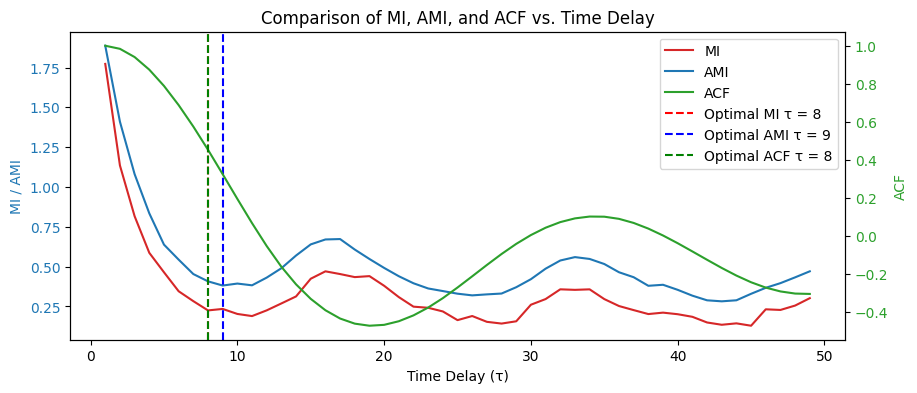

In [103]:
signal = rsp_signals[25]
results = compute_optimal_tau(signal=signal, max_tau=50)
plot_tau_results(results)